# Imports

In [2]:
import numpy as np
import math
import os
import schemdraw
import schemdraw.elements as elm
from PIL import Image
from reportlab.lib.pagesizes import letter
from reportlab.pdfgen import canvas
import random

# Genera Circuito

In [3]:
def dibujo_elemento(va):
  """
  Genera un número aleatorio entre 1 y 5 y devuelve un mensaje correspondiente.
  """
  numero_aleatorio = va
  if numero_aleatorio == 1:
    pass
  elif numero_aleatorio == 2:
    mensaje = elm.Line()
  elif numero_aleatorio == 3:
    mensaje = elm.Resistor()
  elif numero_aleatorio == 4:
    mensaje = elm.SourceV()
  else:  # numero_aleatorio == 5
    mensaje = elm.SourceI()

  return mensaje

# Ejemplo de uso:
#numero_aleatorio = random.randint(2, 5)
#mensaje_obtenido = obtener_mensaje_aleatorio(numero_aleatorio)
#print(mensaje_obtenido)

In [4]:
def generacircuito1malla(filename, h, v, probabilidades=None): 
    if probabilidades is None:
        probabilidades = [np.array([1/4]*4) for _ in range(4)]  # 4 posiciones
    # print("Generador: ", type(probabilidades))

    with schemdraw.Drawing() as d:
        d.config(unit=5)

        def etiqueta(pos, nodo):
            p = probabilidades[pos]
            p_str = "\n".join([f"{i+2}:{p[i]:.2f}" for i in range(len(p))])
            return f"{nodo}\n{p_str}"

        # Posición 0: izquierda vertical
        I1 = dibujo_elemento(v[0]).up().label(etiqueta(2, "2"))

        # Posición 1: superior horizontal
        HS = dibujo_elemento(h[0, 0]).right().label(etiqueta(0, "0"))

        # Posición 2: derecha vertical
        D1 = dibujo_elemento(v[1]).down().label(etiqueta(3, "3"), loc="right", ofst=(3.4, 1.2))

        # Posición 3: inferior horizontal
        HI = dibujo_elemento(h[1, 0]).left().label(etiqueta(1, "1"), ofst=(0, 3))
        d.save(filename)
        

In [21]:
def generacircuito2mallas(filename, h, v, probabilidades=None):
    if probabilidades is None:
        probabilidades = [np.array([1/4]*4) for _ in range(7)]  # 7 posiciones

    def etiqueta(pos, nodo):
        return "\n".join([f"{nodo}"] + [f"{i+2}:{p:.2f}" for i, p in enumerate(probabilidades[pos])])

    with schemdraw.Drawing() as d:
        d.config(unit=5)

        # Posición 4 (v[0]): izquierda vertical
        V1 = dibujo_elemento(v[0]).up().label(etiqueta(4, "4"))

        # Posición 0 (h[0,0]): superior horizontal izquierda
        R1 = dibujo_elemento(h[0, 0]).right().label(etiqueta(0, "0"))

        d.push()
        # Posición 5 (v[1]): centro vertical entre mallas
        R3 = dibujo_elemento(v[1]).down().label(etiqueta(5, "5"))
        d.pop()

        # Posición 1 (h[0,1]): superior horizontal derecha
        I0 = dibujo_elemento(h[0, 1]).right().label(etiqueta(1, "1"))

        # Posición 6 (v[2]): derecha vertical
        I1 = dibujo_elemento(v[2]).down().label(etiqueta(6, "6"),loc="right", ofst=(3.4, 1.2))

        # Posición 3 (h[1,1]): inferior horizontal derecha
        L2 = dibujo_elemento(h[1, 1]).left().label(etiqueta(3, "3"), ofst=(0, 3))

        # Posición 2 (h[1,0]): inferior horizontal izquierda
        L3 = dibujo_elemento(h[1, 0]).left().label(etiqueta(2, "2"), ofst=(0, 3))
        d.save(filename)

# Funcion va

H:  [5 3]


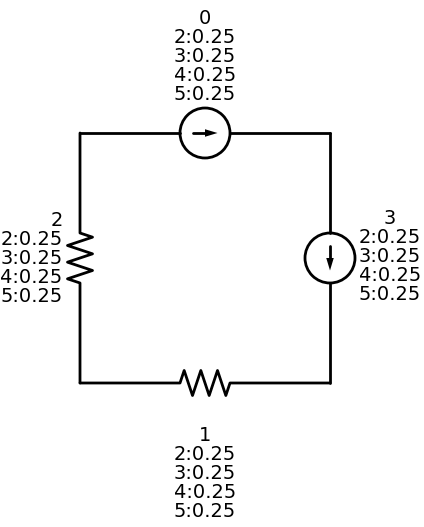

H:  [2 3 5 3]
V:  [[5]
 [2]
 [3]]


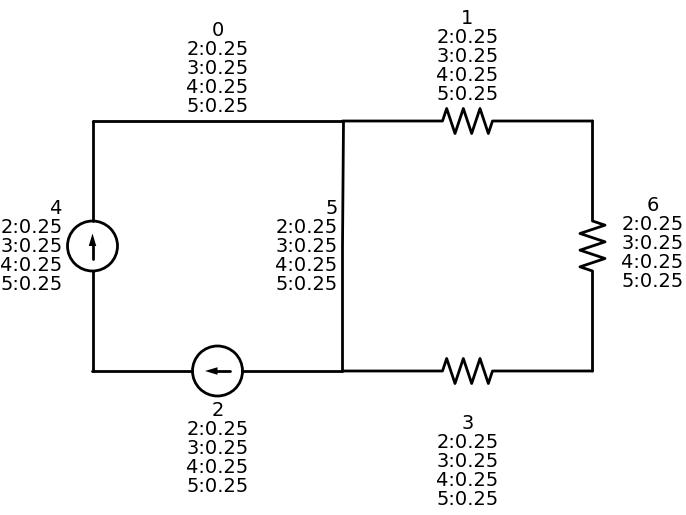

In [8]:

# Función equivalente a va(x, p, m, n) de MATLAB
def va(x, p, m, n):
    """
    Genera una matriz de m x n con elementos de x, siguiendo la distribución p.
    """
    return np.random.choice(x, size=(m, n), p=p)

# Ejemplo de prueba 1 malla
x = [2, 3, 4, 5]
p = [0.25, 0.25, 0.25, 0.25]
H = va(x, p, 2, 1)
V = va(x, p, 2, 1)

print("H: ",H.flatten())


generacircuito1malla('',H,V)

# Ejemplo de prueba 2 mallas
x = [2, 3, 4, 5]
H = va(x, p, 2, 2)
V = va(x, p, 3, 1)

print("H: ",H.flatten())
print("V: ",V)

generacircuito2mallas('',H,V)



# Actividad 1

In [9]:
# Simulación para la Actividad 1 (circuito de una malla)
# Evaluamos dos criterios de invalidez según las leyes de Kirchhoff

experimentos = 100_000
nocumple_corriente = 0
nocumple_voltaje = 0

for _ in range(experimentos):
    H = va(x, p, 1, 2)
    V = va(x, p, 1, 2)
    elementos = np.concatenate([H.flatten(), V.flatten()])

    # Criterio 1: más de una fuente de corriente (5)
    if np.sum(elementos == 5) > 1:
        nocumple_corriente += 1

    # Criterio 2: solo voltajes (4) y cortos (2), pero no todos cortos
    if np.all(np.isin(elementos, [2, 4])) and np.any(elementos == 4) and not np.all(elementos == 2):
        nocumple_voltaje += 1

# Resultados experimentales
fr_corriente = nocumple_corriente / experimentos
fr_voltaje = nocumple_voltaje / experimentos
fr_total = (nocumple_corriente + nocumple_voltaje) / experimentos

# Resultados teóricos
total_combinaciones = 4**4  # 4 elementos, 4 opciones cada uno
# Combinaciones con 2 o más fuentes de corriente
inv_corriente = (
    (math.comb(4, 2) * 3**2) +  # 2 fuentes de corriente
    (math.comb(4, 3) * 3) +     # 3 fuentes de corriente
    1                              # 4 fuentes de corriente
)
teorico_corriente = inv_corriente / total_combinaciones

# Combinaciones con solo 2 y 4 (16 en total), excluyendo todos 2
teorico_voltaje = (2**4 - 1) / total_combinaciones
teorico_total = teorico_corriente + teorico_voltaje

fr_corriente, fr_voltaje, fr_total, teorico_corriente, teorico_voltaje, teorico_total


(0.26234, 0.0584, 0.32074, 0.26171875, 0.05859375, 0.3203125)

# Actividad 2

In [10]:
# Simulación para la Actividad 2 (circuito de dos malla)
# Evaluamos tres criterios de invalidez según las leyes de Kirchhoff

# H, V, elementos_generados = generar_malla_valida()
# print(H, V, elementos_generados)

# Simulación
experimentos = 100_000
inv_fuentes_voltaje = 0
inv_fuentes_corriente = 0
inv_total = 0
inv_todas_resistencias = 1

for _ in range(experimentos):

    H = va(x, p, 1, 4).flatten()
    V = va(x, p, 1, 3).flatten()
    elementos = np.concatenate([H, V])

    # print("H: ", H.flatten())
    # print("V: ", V.flatten())
    # print("Elementos: ", elementos)
    
    malla_izq = np.array([elementos[i] for i in [0, 2, 4, 5]])
    malla_der = np.array([elementos[i] for i in [1, 3, 5, 6]])
    elem_medio = elementos[5]
    borde_malla = np.array([elementos[i] for i in [0,1,2,3,4,6]])

    # print("Malla Izq: ", malla_izq)
    # print("Malla Der: ", malla_der)
    # print("Borde Malla: ", borde_malla)
    # print("Elemento Medio: ", elem_medio)

    # Restricción 1: dos fuentes de voltaje en la misma malla
    corto = 2
    fuente_voltaje = 4
    fuente_corriente = 5
    invalido_voltaje = False
    invalido_corriente = False
    # --------- Malla izquierda [0,2,4] --------- #
    match np.sum(malla_izq == fuente_voltaje):
        case 1:
            if np.sum(malla_izq == corto) > 2:
                invalido_voltaje = True
        case 2:
            if np.sum(malla_izq == corto) > 1:
                invalido_voltaje = True
        case 3:
            if np.sum(malla_izq == corto) > 0:
                invalido_voltaje = True
        case 4:
            invalido_voltaje = True
    # --------- Malla derecha [1,3,6] --------- #
    match np.sum(malla_der == fuente_voltaje):
        case 1:
            if np.sum(malla_der == corto) > 2:
                invalido_voltaje = True
        case 2:
            if np.sum(malla_der == corto) > 1:
                invalido_voltaje = True
        case 3:
            if np.sum(malla_der == corto) > 0:
                invalido_voltaje = True
        case 4:
            invalido_voltaje = True
    # --------- Malla exterior --------- #
    match np.sum(borde_malla == fuente_voltaje):
        case 1:
            if np.sum(borde_malla == corto) > 4:
                invalido_voltaje = True
        case 2:
            if np.sum(borde_malla == corto) > 3:
                invalido_voltaje = True
        case 3:
            if np.sum(borde_malla == corto) > 2:
                invalido_voltaje = True
        case 4:
            if np.sum(borde_malla == corto) > 1:
                invalido_voltaje = True
        case 5:
            if np.sum(borde_malla == corto) > 0:
                invalido_voltaje = True
        case 6:
            invalido_voltaje = True

    # 
    if invalido_voltaje:
        inv_fuentes_voltaje += 1


    # Restricción 2: dos fuentes de corriente en la misma malla

    # Mallas sin el elemento compartido [5]
    malla_izq2 = np.array([elementos[i] for i in [0, 2, 4]])
    malla_der2 = np.array([elementos[i] for i in [1, 3, 6]])
    
    if (np.sum(malla_izq2 == fuente_corriente) > 1 or np.sum(malla_der2 == fuente_corriente) > 1):
        invalido_corriente = True
    elif np.sum(malla_izq2 == fuente_corriente) == 1 and np.sum(malla_der2 == fuente_corriente) == 1 and elem_medio == fuente_corriente:
        invalido_corriente = True

    if invalido_corriente:
        inv_fuentes_corriente += 1
    
    if invalido_voltaje or invalido_corriente:
        inv_total += 1


fr_1 = inv_fuentes_voltaje / experimentos
fr_2 = inv_fuentes_corriente / experimentos

print("Frecuencia invalidez voltaje: ", fr_1)
print("Frecuencia invalidez corriente: ", fr_2)
fr_inv = inv_total / experimentos
print("Frecuencia invalidez total: ", fr_inv)
fr_valido = 1 - fr_inv
print("Frecuencia válida: ", fr_valido)

# ---------------------------------- Cálculo teórico -------------------

# # P[V] - Voltajes 
# # 1933 / 16384 = 0.118
# # P[I] - Corrientes
# # 5449 / 16384 = 0.333

# total_combinaciones = 4**7 ## 16384 combinaciones posibles (7 elementos, 4 opciones cada uno)

# ---------------------- Corrientes I -------------------

inval_corriente_izq = (
    ((math.comb(3, 2) * 3) +     # 2 fuentes de corriente en una malla
    1) *                         # 3 fuentes de corriente en una malla
    4**4                         # 4 opciones y 4 elementos en la otra malla
) # = 2560

inval_corriente_der = (
    ((math.comb(3, 2) * 3) +     # 2 fuentes de corriente en una malla
    1) *                         # 3 fuentes de corriente en una malla
    4**4                         # 4 opciones y 4 elementos en la otra malla
) # = 2560

inval_corriente_medio = (
    (math.comb(3, 1) * 3**2) * # = 27 Exactamente 1 fuente de corriente en una malla
    (math.comb(3, 1) * 3**2) * # = 27 Exactamente 1 fuente de corriente en la otra malla
    1                          # 1 fuente de corriente en el medio
) # = 729

# Superposición de fuentes de corriente en ambas mallas
# 10 formas inválidas por cada malla independiente y 4 opciones para el medio = 10 * 10 * 4 = 400
# Invalidez = 2560 + 2560 + 729 - 400 = 5449


inv_corriente_medio = inval_corriente_der ** 2 * 1  # = 729

teorico_corriente = ((inval_corriente_izq + inval_corriente_der + inval_corriente_medio) - 400) / 16384

print("Invalidez teórica total (corriente): ", teorico_corriente) # = 5449

# ---------------------- Voltajes V -------------------

# Una malla (dos o más fuentes de voltaje)
inval_voltaje_izq = (
    (2 ** 4) *              # fuente de voltaje o corto (2 opciones) en cada posicion (4)
    4**3                     # 4 opciones y 3 posiciones restantes en la otra malla
) # = 16 * 64 = 1024

inval_voltaje_der = (
    (2 ** 4) *              # fuente de voltaje o corto (2 opciones) en cada posicion (4)
    4**3                     # 4 opciones y 3 posiciones restantes en la otra malla
) # = 16 * 64 = 1024

# 15 / 256 

inval_voltaje_ext = (
    (2 ** 6) *              # fuentes de voltaje o cortos (2 opciones) en cada posicion (6) 
    4**1                    # 4 opciones y 1 posicion restante (medio)
) # = 256

# Superposición de fuentes de voltaje en ambas mallas
# 2 elementos (voltaje - corto) en 3 posiciones por malla, 2 elementos válidos para el medio (corriente - resistencia)
# Invalidez = 2**3 * 2**3 * 2 = 128

# Superposición de fuentes de voltaje en una malla y la exterior
# 2 elementos (voltaje - corto) en 6 posiciones de la malla exterior, 2 elementos inválidos para el medio (voltaje - corto)
# Invalidez = 2**6 * 2 = 128

# Superposición de fuentes de voltaje en ambas mallas y la exterior 
# 2 elementos (voltaje - corto) en 3 posiciones por malla, 2 elementos inválidos para el medio (voltaje - corto)
# Invalidez = 2**3 * 2**3 * 2 = 128

# Se restan las combinaciones de solo cortos que cumplen LVK (115)

teorico_voltaje = (
    inval_voltaje_izq + 
    inval_voltaje_der + 
    inval_voltaje_ext - 
    128 - 128 - 128 + 128 - (115) # = 1933
) / 16384

print("Invalidez teórica total (voltaje): ", teorico_voltaje) # = 1933

teorico_total = teorico_corriente + teorico_voltaje - (300 / 16384)

print("Frecuencia invalidez total: ", teorico_total)

Frecuencia invalidez voltaje:  0.11697
Frecuencia invalidez corriente:  0.33301
Frecuencia invalidez total:  0.43332
Frecuencia válida:  0.5666800000000001
Invalidez teórica total (corriente):  0.33258056640625
Invalidez teórica total (voltaje):  0.11798095703125
Frecuencia invalidez total:  0.4322509765625


# Actividad 3

## Probabilidad condicional 1 malla

In [11]:
def prob_condicional(elementos, x):
    p = np.ones(len(x), dtype=float)

    # Regla 1: máximo una fuente de corriente
    if np.sum(np.array(elementos) == 5) >= 1:
        p[np.array(x) == 5] = 0

    # Regla 2: evitar que el circuito se forme solo con fuentes de voltaje y cortos
    # pero permitir si todos son cortos
    if len(elementos) == 3:
        # solo hay cortos (2) y voltajes (4)
        if all(e in [2, 4] for e in elementos):
            # si no hay cortos, no permitir más voltajes o cortos
            if 2 not in elementos:
                # todos son voltajes (no permitido)
                p[np.isin(x, [2, 4])] = 0
            # si hay fuentes de voltaje y no hay resistencias
            elif 4 in elementos and 3 not in elementos:
                # hay mezcla de 2 y 4, pero sin resistencias: no permitir más 2 ni 4
                p[np.isin(x, [2, 4])] = 0
            elif 2 in elementos and 4 not in elementos:
                # si todos los elementos son cortos (2), no permitir fuente de voltaje
                p[np.isin(x, [4])] = 0

    p = p / np.sum(p)
    return p

## Generador circuito de una malla

In [12]:

def generar_malla_valida():
    x = [2, 3, 4, 5]
    H = np.zeros((2, 1), dtype=int)
    V = np.zeros((2, 1), dtype=int)
    elementos = []
    probabilidades = []

    for i in range(4):
        p = prob_condicional(elementos, x)
        # print(p)
        elegido = np.random.choice(x, p=p)
        elementos.append(elegido)
        probabilidades.append(p)
        if i < 2:
            H[i, 0] = elegido
        else:
            V[i - 2, 0] = elegido
    # print(probabilidades)
    return H, V, elementos, probabilidades


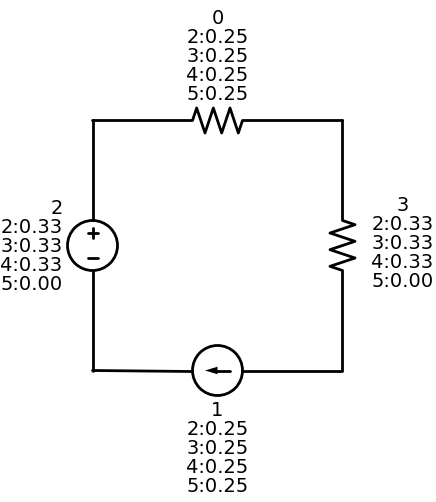

In [24]:

H, V, elementos_generados, probabilidades = generar_malla_valida()
# print(H, V, elementos_generados)
# print(probabilidades)

generacircuito1malla('', H, V, probabilidades)


## Valida Generador de una malla

In [14]:
# Validacion degenerador de una malla
# Se toma validacion de la actividad 1

experimentos = 100_000
nocumple_corriente = 0
nocumple_voltaje = 0

for _ in range(experimentos):
    H, V, e, probabilidades  = generar_malla_valida()
    elementos = np.concatenate([H.flatten(), V.flatten()])

    # Criterio 1: más de una fuente de corriente (5)
    if np.sum(elementos == 5) > 1:
        nocumple_corriente += 1
        print("No cumple corriente: ", elementos)

    # Criterio 2: solo voltajes (4) y cortos (2), pero no todos cortos
    if np.all(np.isin(elementos, [2, 4])) and np.any(elementos == 4) and not np.all(elementos == 2):
        nocumple_voltaje += 1
        print("No cumple voltaje: ", elementos)

# fr_corriente, fr_voltaje, fr_total, teorico_corriente, teorico_voltaje, teorico_total
print("No cumple corriente: ", nocumple_corriente)
print("No cumple voltaje: ", nocumple_voltaje)
print("No cumple total: ", nocumple_corriente + nocumple_voltaje)


No cumple corriente:  0
No cumple voltaje:  0
No cumple total:  0


# Actividad 4

## Probabilidad condicional 2 mallas

In [15]:
def prob_condicional_dos_mallas(elementos, x):
    p = np.ones(len(x), dtype=float)
    num_elem = len(elementos)

    # Mapeo corregido de posiciones a mallas
    izquierda = {0, 2, 4, 5}
    derecha = {1, 3, 5, 6}
    externa = {0, 1, 2, 3, 4, 6}

    def get_submalla(indices):
        return [elementos[i] for i in indices if i < len(elementos)]

    malla_izq = get_submalla(izquierda)
    malla_der = get_submalla(derecha)
    malla_ext = get_submalla(externa)

    siguiente = num_elem
    pertenece_izq = siguiente in izquierda
    pertenece_der = siguiente in derecha
    pertenece_ext = siguiente in externa

    # Reglas de invalidez por corriente
    if len(elementos) == 5:
        if elementos[4]==5:
          p[x.index(5)] = 0
    if pertenece_izq and malla_izq.count(5) >= 1:
        p[x.index(5)] = 0
    if pertenece_der and malla_der.count(5) >= 1:
        p[x.index(5)] = 0

    # Reglas de voltajes: no solo 2 y 4 con al menos un 4
    # def invalida_por_voltaje(malla):
    #     return all(e in [2, 4] for e in malla) and 3 not in malla and malla.count(4) >= 1

    # print("Malla Izq: ", malla_izq)
    # print("Malla Der: ", malla_der)
    # print("Malla Ext: ", malla_ext)

    if pertenece_izq:
        if malla_izq.count(2) == 3 or malla_izq.count(4) == 3:
            p[np.isin(x, [4])] = 0
        if (malla_izq.count(2) + malla_izq.count(4)) == 3:
            p[np.isin(x, [2,4])] = 0
    if pertenece_der:
        if malla_der.count(2) == 3 or malla_der.count(4) == 3 :
            p[np.isin(x, [4])] = 0
        if (malla_der.count(2)  + malla_der.count(4)) == 3: 
            p[np.isin(x, [2,4])] = 0
    if pertenece_ext:
        if malla_ext.count(2) == 5 or malla_ext.count(4) == 5 :
            p[np.isin(x, [4])] = 0
        if  (malla_ext.count(2) + malla_ext.count(4)) == 5:
            p[np.isin(x, [2,4])] = 0

    p = p / np.sum(p)
    return p

## Generador circuito de dos mallas

In [16]:
# Llena prinero los elementos del vector H y luego los de V
def generar_dos_mallas_valida():
    x = [2, 3, 4, 5]
    H = np.zeros((2, 2), dtype=int)  # Matriz 2x2
    V = np.zeros((3, 1), dtype=int)  # Vector columna 3x1
    elementos = []
    probabilidades = []

    for i in range(7):
        p = prob_condicional_dos_mallas(elementos, x)
        
        elegido = np.random.choice(x, p=p)
        elementos.append(elegido)

        if i < 4:
            row = i // 2
            col = i % 2
            # print("H: ", row ," ", col, " ",elegido)
            H[row, col] = elegido  # Llenar por filas
        else:
            # print("V: ", i - 4 ," ", 0, " ",elegido)
            V[i - 4, 0] = elegido  # Llenar vertical
        # print(p)
        # print("\n")
        probabilidades.append(p)


    return H, V, elementos, probabilidades



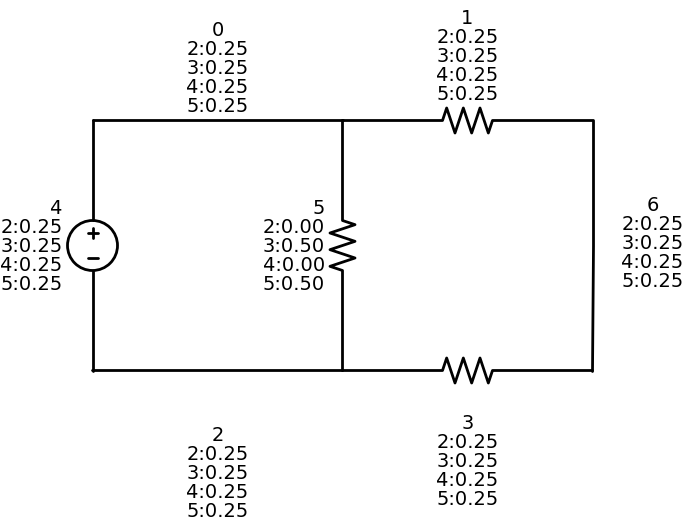

In [25]:
H, V, elementos_generados, probabilidades = generar_dos_mallas_valida()

# print(H, V, elementos_generados)
#  [2 2 4 2 5 4 2]
# H = np.array([[4, 2], [4, 2]])
# V= np.array([[4], [5], [4]])

generacircuito2mallas('',H, V,probabilidades)

## Valida generador dos mallas

In [26]:
# Simulación
experimentos = 100_000
inv_fuentes_voltaje = 0
inv_fuentes_corriente = 0
inv_total = 0
inv_todas_resistencias = 1

for _ in range(experimentos):

    H,V,e,p =generar_dos_mallas_valida()

    elementos = np.concatenate([H.flatten(), V.flatten()])

    malla_izq = np.array([elementos[i] for i in [0, 2, 4, 5]])
    malla_der = np.array([elementos[i] for i in [1, 3, 5, 6]])
    elem_medio = elementos[5]
    borde_malla = np.array([elementos[i] for i in [0,1,2,3,4,6]])

    # print("Malla Izq: ", malla_izq)
    # print("Malla Der: ", malla_der)
    # print("Borde Malla: ", borde_malla)
    # print("Elemento Medio: ", elem_medio)

    # Restricción 1: dos fuentes de voltaje en la misma malla
    corto = 2
    fuente_voltaje = 4
    fuente_corriente = 5
    invalido_voltaje = False
    invalido_corriente = False
    # --------- Malla izquierda [0,2,4] --------- #
    match np.sum(malla_izq == fuente_voltaje):
        case 1:
            if np.sum(malla_izq == corto) > 2:
                invalido_voltaje = True
        case 2:
            if np.sum(malla_izq == corto) > 1:
                invalido_voltaje = True
        case 3:
            if np.sum(malla_izq == corto) > 0:
                invalido_voltaje = True
        case 4:
            invalido_voltaje = True
    # --------- Malla derecha [1,3,6] --------- #
    match np.sum(malla_der == fuente_voltaje):
        case 1:
            if np.sum(malla_der == corto) > 2:
                invalido_voltaje = True
        case 2:
            if np.sum(malla_der == corto) > 1:
                invalido_voltaje = True
        case 3:
            if np.sum(malla_der == corto) > 0:
                invalido_voltaje = True
        case 4:
            invalido_voltaje = True
    # --------- Malla exterior --------- #
    match np.sum(borde_malla == fuente_voltaje):
        case 1:
            if np.sum(borde_malla == corto) > 4:
                invalido_voltaje = True
        case 2:
            if np.sum(borde_malla == corto) > 3:
                invalido_voltaje = True
        case 3:
            if np.sum(borde_malla == corto) > 2:
                invalido_voltaje = True
        case 4:
            if np.sum(borde_malla == corto) > 1:
                invalido_voltaje = True
        case 5:
            if np.sum(borde_malla == corto) > 0:
                invalido_voltaje = True
        case 6:
            invalido_voltaje = True

    # 
    if invalido_voltaje:
        print("Invalido voltaje elementos: ", elementos)
        inv_fuentes_voltaje += 1


    # Restricción 2: dos fuentes de corriente en la misma malla

    # Mallas sin el elemento compartido [5]
    malla_izq2 = np.array([elementos[i] for i in [0, 2, 4]])
    malla_der2 = np.array([elementos[i] for i in [1, 3, 6]])
    
    if (np.sum(malla_izq2 == fuente_corriente) > 1 or np.sum(malla_der2 == fuente_corriente) > 1):
        invalido_corriente = True
    elif np.sum(malla_izq2 == fuente_corriente) == 1 and np.sum(malla_der2 == fuente_corriente) == 1 and elem_medio == fuente_corriente:
        invalido_corriente = True

    if invalido_corriente:
        inv_fuentes_corriente += 1
    
    if invalido_voltaje or invalido_corriente:
        inv_total += 1

print("Frecuencia invalidez voltaje: ", inv_fuentes_voltaje / experimentos)
print("Frecuencia invalidez corriente: ", inv_fuentes_corriente / experimentos)
print("Frecuencia invalidez total: ", inv_total )
print("Frecuencia invalidez total 2: ", inv_fuentes_corriente + inv_fuentes_voltaje)
inv_total = inv_fuentes_voltaje + inv_fuentes_corriente
fr_inv = inv_total / experimentos
fr_valido = 1 - fr_inv
print("Frecuencia inválida: ", fr_inv)
print("Frecuencia válida: ", fr_valido)


Frecuencia invalidez voltaje:  0.0
Frecuencia invalidez corriente:  0.0
Frecuencia invalidez total:  0
Frecuencia invalidez total 2:  0
Frecuencia inválida:  0.0
Frecuencia válida:  1.0


# Actividad 5

## Generador masivo de diagramas en pdf

### Para una malla

[array([0.25, 0.25, 0.25, 0.25]), array([0.25, 0.25, 0.25, 0.25]), array([0.25, 0.25, 0.25, 0.25]), array([0.25, 0.25, 0.25, 0.25])]


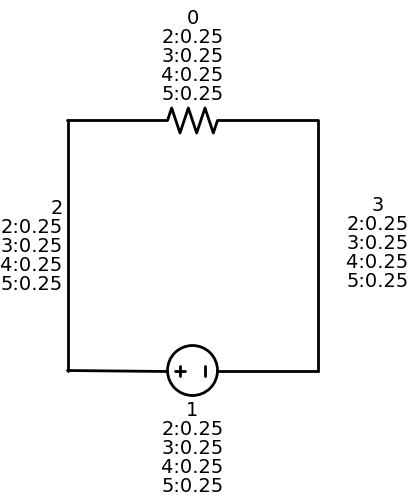

[array([0.25, 0.25, 0.25, 0.25]), array([0.25, 0.25, 0.25, 0.25]), array([0.25, 0.25, 0.25, 0.25]), array([0.25, 0.25, 0.25, 0.25])]


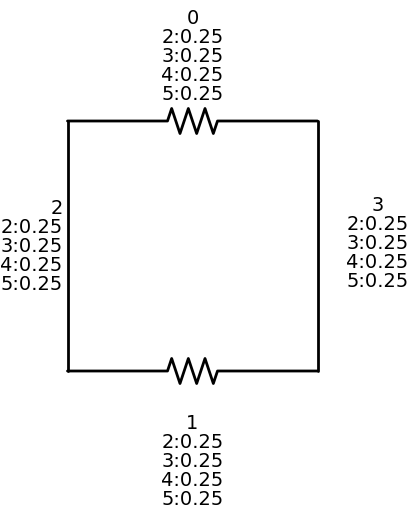

[array([0.25, 0.25, 0.25, 0.25]), array([0.33333333, 0.33333333, 0.33333333, 0.        ]), array([0.33333333, 0.33333333, 0.33333333, 0.        ]), array([0.33333333, 0.33333333, 0.33333333, 0.        ])]


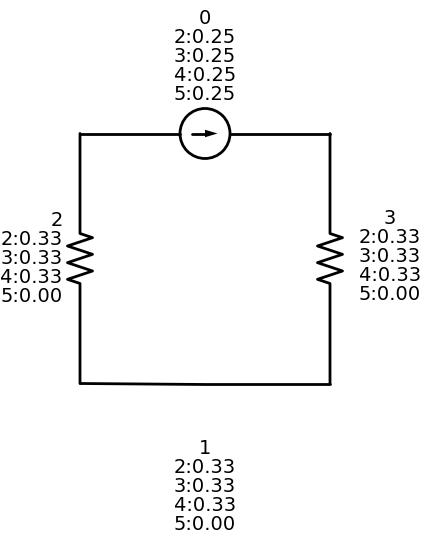

[array([0.25, 0.25, 0.25, 0.25]), array([0.25, 0.25, 0.25, 0.25]), array([0.25, 0.25, 0.25, 0.25]), array([0.25, 0.25, 0.25, 0.25])]


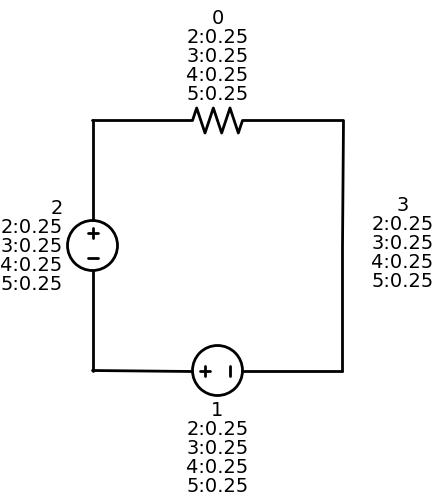

[array([0.25, 0.25, 0.25, 0.25]), array([0.33333333, 0.33333333, 0.33333333, 0.        ]), array([0.33333333, 0.33333333, 0.33333333, 0.        ]), array([0.33333333, 0.33333333, 0.33333333, 0.        ])]


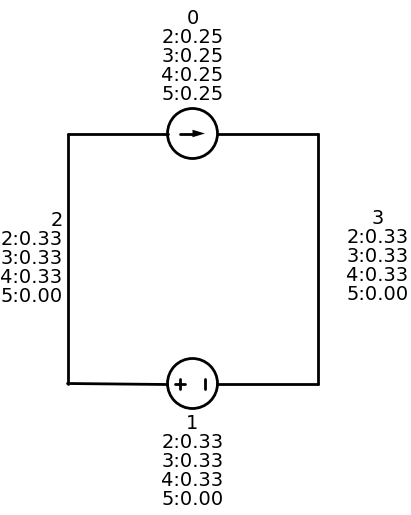

✅ PDF generado: circuitos_una_malla.pdf


In [27]:
# Carpeta temporal
img_folder = 'circuitos_temp'
os.makedirs(img_folder, exist_ok=True)

# Lista para guardar las rutas de imágenes
image_paths = []

# Número de circuitos a generar
n = 5

for i in range(n):
    H, V, elementos_generados, probabilidades = generar_malla_valida()
    # print(H, V, elementos_generados)
    print(probabilidades)    
    filename = os.path.join(img_folder, f'circuito_{i+1}.png')
    generacircuito1malla(filename, H, V, probabilidades)
    image_paths.append(filename)

pdf_filename = 'circuitos_una_malla.pdf'
c = canvas.Canvas(pdf_filename, pagesize=letter)
width, height = letter

for idx, img_path in enumerate(image_paths):
    c.setFont("Helvetica-Bold", 16)
    c.drawString(100, height - 50, f'Circuito unimalla: {idx + 1}')
    c.drawImage(img_path, 100, 200, width=400, preserveAspectRatio=True, mask='auto')
    c.showPage()

c.save()
print(f'✅ PDF generado: {pdf_filename}')

for img_path in image_paths:
    os.remove(img_path)

if not os.listdir(img_folder):
    os.rmdir(img_folder)

### Para dos mallas

[[2 3]
 [5 2]] [[2]
 [2]
 [4]] [2, 3, 5, 2, 2, 2, 4]


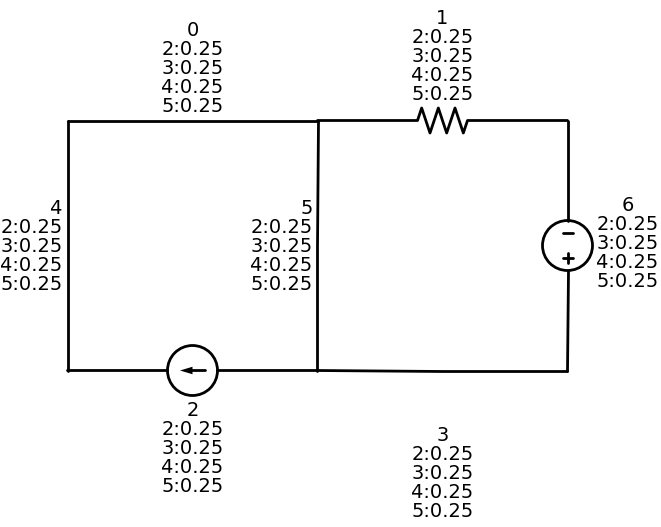

[[2 4]
 [2 4]] [[2]
 [3]
 [5]] [2, 4, 2, 4, 2, 3, 5]


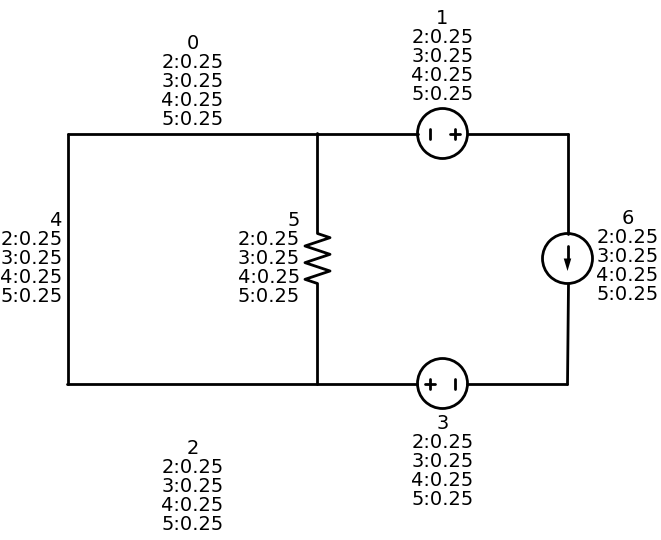

[[5 2]
 [2 4]] [[3]
 [3]
 [4]] [5, 2, 2, 4, 3, 3, 4]


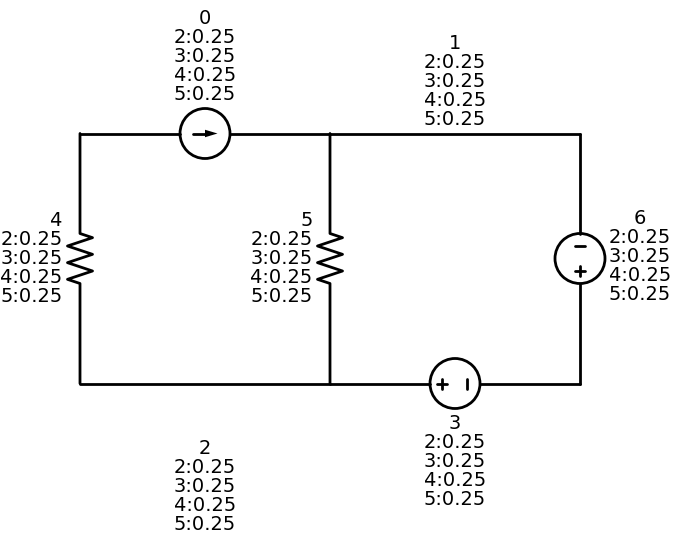

[[2 2]
 [2 3]] [[3]
 [2]
 [4]] [2, 2, 2, 3, 3, 2, 4]


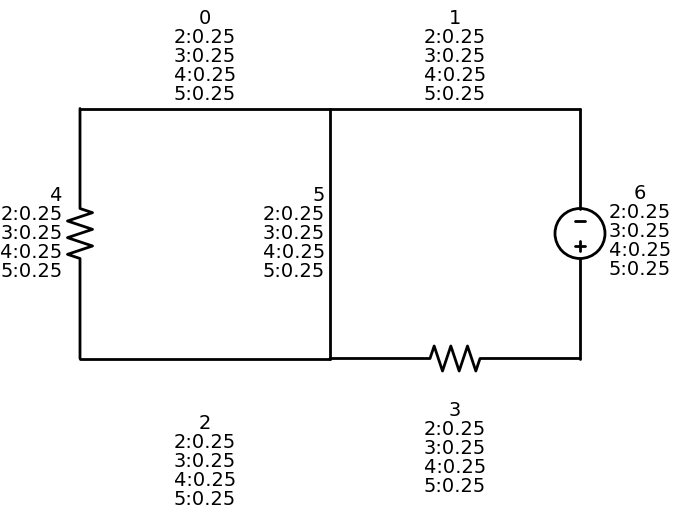

[[2 2]
 [2 3]] [[2]
 [5]
 [4]] [2, 2, 2, 3, 2, 5, 4]


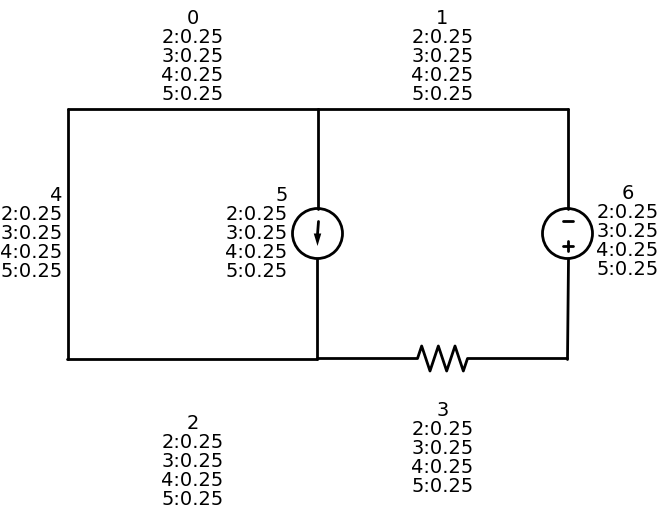

✅ PDF generado: todos_los_circuitos_2mallas.pdf


In [28]:
#  [2 2 4 2 5 4 2]
# H = np.array([[4, 2], [4, 2]])
# V= np.array([[4], [5], [4]])

# Carpeta temporal
img_folder = 'circuitos_temp'
os.makedirs(img_folder, exist_ok=True)

# Lista para guardar las rutas de imágenes
image_paths2 = []

# Número de circuitos a generar
n = 5

for i in range(n):
    H, V, elementos_generados, probabilidades = generar_dos_mallas_valida()
    print(H, V, elementos_generados)
    filename2 = os.path.join(img_folder, f'circuito_doble_malla_{i+1}.png')
    generacircuito2mallas(filename2, H, V)
    image_paths2.append(filename2)

# Crear el PDF
pdf_filename2 = 'todos_los_circuitos_2mallas.pdf'
c = canvas.Canvas(pdf_filename2, pagesize=letter)
width, height = letter

for idx, img_path2 in enumerate(image_paths2):
    c.setFont("Helvetica-Bold", 16)
    c.drawString(100, height - 50, f'Circuito doble malla: {idx + 1}')
    c.drawImage(img_path2, 100, 200, width=400, preserveAspectRatio=True, mask='auto')
    c.showPage()

c.save()
print(f'✅ PDF generado: {pdf_filename2}')

# Eliminar imágenes
for img_path in image_paths2:
    os.remove(img_path)

if not os.listdir(img_folder):
    os.rmdir(img_folder)